In [1]:

# ****************************************************************************
#                       DATA ORGANIZATION and FORMATING
# ****************************************************************************

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

# ------ LOAD data-tables ---------------------------------------------------- 
# List of clinical table with features and timepoints
# => ClinicalData_Klinisk.csv ------------ Patients list and clinical data  (sheets "Klinik fra Randi")
#                                        - (including medications, treatments etc...)
# => ClinicalData_Oversikt.csv ----------- Sample list of all timepoint measurements (sheet "Oversikt")
#                                        - (in theory 5 each patient)
# => Lipoproteinene_Combined2.csv -------- Lipoprotein measurements (blood serum)
# => Metabolittene_comb_final_clean.csv -- Metabolomics measurments (blood serum)

path_Klinisk  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Klinisk.csv" 
path_Oversikt = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Oversikt.csv" 
path_Lipopro  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Lipoproteinene_Combined2.csv" 
path_Metabol  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Metabolittene_comb_final_clean.csv" 

root_path = os.path.dirname(path_Lipopro)
             
# Load clinical data files, Lipoprotein and Metabolites measurments files 
# NOTE: There are some redundant columns!
CD_klinisk = pd.read_csv( path_Klinisk,  header=1, index_col=False)
CD_oversik = pd.read_csv( path_Oversikt, header=0, index_col=False)
LP_measure = pd.read_csv( path_Lipopro,  header=0, index_col=False)
MB_measure = pd.read_csv( path_Metabol,  header=0, index_col=False)


# ------ PRUNING the data ----------------------------------------------------
# Extract the timepoints as defined by Guro. We could also redifine by looking 
# dates or use dates to find matching measurments between different dataframes 
sele_oversik  = [ "PatientID", 
                  "Samplenames lipo", "Names date modified", "Samling date", 
                  "Dato stråleterapi", 
                  "Timepoint", "Timepoint_kodet",
                  "Alder", "BMI", 
                  "HEr2 ", "ER ", "PGR","kjemo", "herceptin" , "hormornbeh",
                  "FatPAS.1", "FatPAS.2", "FatPAS.3", "FatPAS.4", "FatPAS.5"]
CD_samples  = CD_oversik.loc[:,sele_oversik]

# Simplify the names of the Metabolites dataframe columns, removing the unit
names = MB_measure.columns
MB_measure.columns = [xx.split(" (RawConc)")[0] for xx in names]

# Rename column e.g. "Samplenames lipo" in CD_oversik === "name" in LP_measure
CD_samples = CD_samples.rename(columns={"Samplenames lipo": "Samplename"})
LP_measure = LP_measure.rename(columns={"name": "Samplename"})
MB_measure = MB_measure.rename(columns={"Sample Name": "Samplename"})
CD_samples = CD_samples.rename(columns={"HEr2 ": "HER2"})
CD_samples = CD_samples.rename(columns={"ER ": "ER"})

# Insert a "PatientID" column in LP and MB dataframes (redundant but good practice)
pID = [ xx.split("_")[0] for xx in LP_measure["Samplename"]]
LP_measure.insert( loc=1, column="PatientID", value=pID)
pID = [ xx.split("_")[0] for xx in MB_measure["Samplename"]]
MB_measure.insert( loc=1, column="PatientID", value=pID)


# ! Ensure that the different DFs (CD, LP and MB) have the exact same set of 
#   samples in their list. Use "Samplename" compare and remove those samples
#   that appear only in one dataframe.
# NOTE: check manually on the list what we are actually removing !!!
#       Specifically, LP have less samples than MP and CD
# Use set-difference to find missing samples in LP_measure, then reomve those
# from the list. Finally, subset DFs selecting only common samples
miss_nn = np.setdiff1d( CD_samples["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( CD_samples["Samplename"], miss_nn )
CD_samples = CD_samples.loc[CD_samples["Samplename"].isin(list_nn)]

# As above, but between LP_measure and MB_measure
# NOTE: MB_measure has repeated measurments for a couple of samples !!!
miss_nn = np.setdiff1d( MB_measure["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( MB_measure["Samplename"], miss_nn )
MB_measure = MB_measure.loc[MB_measure["Samplename"].isin(list_nn)]

# Remove quality control measurments: strings starting with "QC"
mask_QC = ["QC" not in xx   for xx in LP_measure["Samplename"]]
CD_samples = CD_samples.loc[ mask_QC, : ]
LP_measure = LP_measure.loc[ mask_QC, : ]
MB_measure = MB_measure.loc[ mask_QC, : ]


# At this point we have the exact same entries in both DataFrames. 
# (Check by running np.setdiff1d in all combinations between the 3 DFs)
# Sort-by name columns "Samplename" and then remove uncategorized timepoints.
CD_samples = CD_samples.sort_values("Samplename")
LP_measure = LP_measure.sort_values("Samplename")
MB_measure = MB_measure.sort_values("Samplename")


# --- Selection by HER2 analysis
# Correct Syntax errors in Time column ('pre ' (with space) instead of 'pre')
idx = CD_samples.index[CD_samples['Timepoint']== 'pre '].tolist()
CD_samples.loc[idx] = CD_samples.loc[idx]['Timepoint'] = 'pre'

# Remove the samples tagged "pre" in HER2 column
#mask = np.array(CD_samples["PGR"] == -100)
# Remove 'nan' values (CD_samples['Timepoint']== '?')
mask = CD_samples["Timepoint_kodet"].isnull().values
CD_samples = CD_samples.loc[ ~mask, : ]
LP_measure = LP_measure.loc[ ~mask, : ]
MB_measure = MB_measure.loc[ ~mask, : ]



# ------ REORGANIZE and SORT variables ---------------------------------------
# Now all DFs the sample measurements sorted in the same order (Samplename)
# Thus, we reindex the rows in all DFs to be the same.
CD_samples = CD_samples.reset_index(drop=True)
LP_measure = LP_measure.reset_index(drop=True)
MB_measure = MB_measure.reset_index(drop=True)

# Reorganize the "covariates" order so that we remove redundant (colinear) 
# factors and we can plot them together based on meaningful grouping
# and order (e.g. class of molecules)
# TG  = tryglyceride
# CH  = total cholesterol
# FC  = free cholesterol
# (EC = esterified cholesterol) 
# PL  = phosppholipids
# AB  = ApoB  (=== particle numbers, for specific class)
# A1  = ApoA (only HDL)
vars_LP_order = [  
                'V1TG', 'V1CH', 'V1FC', 'V1PL', 
                'V2TG', 'V2CH', 'V2FC', 'V2PL', 
                'V3TG', 'V3CH', 'V3FC', 'V3PL', 
                'V4TG', 'V4CH', 'V4FC', 'V4PL', 
                'V5TG', 'V5CH', 'V5FC', 'V5PL', 

                'IDTG', 'IDCH', 'IDFC', 'IDPL',

                'L1TG', 'L1CH', 'L1FC', 'L1PL',
                'L2TG', 'L2CH', 'L2FC', 'L2PL',
                'L3TG', 'L3CH', 'L3FC', 'L3PL',
                'L4TG', 'L4CH', 'L4FC', 'L4PL',
                'L5TG', 'L5CH', 'L5FC', 'L5PL',
                'L6TG', 'L6CH', 'L6FC', 'L6PL',

                'H1TG', 'H1CH', 'H1FC', 'H1PL', 'H1A1', 'H1A2',
                'H2TG', 'H2CH', 'H2FC', 'H2PL', 'H2A1', 'H2A2',
                'H3TG', 'H3CH', 'H3FC', 'H3PL', 'H3A1', 'H3A2',
                'H4TG', 'H4CH', 'H4FC', 'H4PL', 'H4A1', 'H4A2',
                ]
vars_MB_order = [ 'Lysine', 'Histidine', 'Glutamic acid',
                  'Glutamine', 'Asparagine', 'Threonine', 
                  'Glycine', 'Proline',
                  'Phenylalanine', 'Leucine', 'Alanine', 'Tyrosine', 'Valine', 'Isoleucine', 'Methionine',                  
                  'N,N-Dimethylglycine', 'Ornithine', 'Sarcosine',                 
                  '2-Hydroxybutyric acid', '3-Hydroxybutyric acid', '2-Oxoglutaric acid', '2-Aminobutyric acid',
                  'Pyruvic acid', 'Citric acid', 'Acetic acid', 'Lactic acid', 'Succinic acid', 'Formic acid', 'Acetoacetic acid',                  
                  'K-EDTA','Ca-EDTA',                 
                  'Acetone', 'Glycerol',                 
                  'D-Galactose', 'Glucose',                 
                  'Dimethylsulfone',                   
                  'Choline', 'Creatine', 'Creatinine'
                 ]

data = LP_measure.iloc[:,4:]
# Simplify the index (covariates) names by removing the "unit"
names = data.columns.values
names = [ xx.split(" [")[0] for xx in names]
data.columns = names
# select and sort on ly the variables in vars_LP_order
data = data.loc[:,vars_LP_order] 
data = data.reindex(vars_LP_order, axis = 1)
LP_measure = pd.concat( [LP_measure.iloc[:,0:4], data], axis = 1 )

data = MB_measure.iloc[:,2:]
data = data.reindex(vars_MB_order, axis = 1)
MB_measure = pd.concat( [MB_measure.iloc[:,0:2], data], axis = 1 )



# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
CD_samples.to_csv( root_path + "/PyR_Sample_ClinikData.csv"  , header=True, index=True)
LP_measure.to_csv( root_path + "/PyR_Lipoproteine.csv", header=True, index=True)
MB_measure.to_csv( root_path + "/PyR_Metabolittene.csv", header=True, index=True)




# ------ LOAD SURVIVAL data-tables -------------------------------------------
# List of patients and importantly the survival. We need to load as .xlsx 
# because there are comment columns with "commas" that alter the table when 
# uploaded as .csv file
# Survival state:  1= lever,  2= tilbakefall, 3= kreftdød,     4= annen død 
#                  1= alive,  2= relapse,     3= cancer death, 4= other death 

path_Survival = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Radiationstudy_survival_modified_MS.xlsx" 
CD_survival = pd.read_excel( path_Survival,  header=0, index_col=False )

# we do not take columns: 
# 6 - Komorbidity - a description and requires manual conversion to some categorical data type
sele_survival = [ 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12]
name_conversion = {"PID":             "PatientID",
                   "Dato start RT":   "Date_StartRadio",
                   "10-års-kontroll lege/siste livstegn": "Date_10yCheck",
                   "QOL-skjema":           "Date_QOLquestionnaire",
                   "Kun QOL":              "With_QOL",
                   "Antall dettatt":       "N_Participant",
                   "Metastase/ ny kreft":  "NewCancer",
                   "Dato mors":            "Date_Death",
                   "Dato tilbakefall":     "Date_Relapse",
                   "Oppfølgingstid":       "Followup",
                   "Status, 1= lever, 2 = tilbakefall, 3 = kreftdød, 4 = annen død":   "Status"
                  }

CD_survival = CD_survival.iloc[:, sele_survival]
CD_survival = CD_survival.rename(columns= name_conversion)

# Uniformize the date from strings to datetime64 
# NOTE: NAN strings (possibly no follow up due to death) are convered into
#       NaT in datetime64. To find NaT use .isnull() method
CD_survival["Date_StartRadio"] = pd.to_datetime(CD_survival["Date_StartRadio"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_10yCheck"]   = pd.to_datetime(CD_survival["Date_10yCheck"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_Death"]      = pd.to_datetime(CD_survival["Date_Death"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_Relapse"]    = pd.to_datetime(CD_survival["Date_Relapse"], infer_datetime_format=True, errors='coerce')
CD_survival["Date_QOLquestionnaire"] = pd.to_datetime(CD_survival["Date_QOLquestionnaire"], infer_datetime_format=True, errors='coerce')

# Replace NaN and convert scolumns into simple 0-1 values
mask    = CD_survival["N_Participant"].isnull()
CD_survival.loc[mask, "N_Participant"] = 0
mask    = CD_survival["N_Participant"].isnull()
CD_survival.loc[mask, "N_Participant"] = 0
mask    = CD_survival["NewCancer"].isnull()
CD_survival.loc[mask, "NewCancer"] = 0

# Simplify survival state in binary: 0 deaths of any type; 1 for alive
mask_1 = CD_survival["Status"] == 1

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
mask_2 = CD_survival["Status"] >= 2
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


CD_survival.loc[mask_1, "Status_code"] = 1
CD_survival.loc[mask_2, "Status_code"] = 0
#mask = CD_survival.loc[:, "Status_code"].isnull() 


# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
CD_survival.to_csv( root_path + "/PyR_Patients_Survival.csv" , header=True, index=True)




# ------ COMBINE ----------------------------------------------------------------
# Add information on survival in the sample information DF: CD_samples
# Initialize "0" column and then, for all alive PatientID replace with "1"
CD_samples.insert( loc=8, column="Status_code", value=0)
mask = CD_survival.loc[:, "Status_code"] == 1
pIDList = CD_survival.loc[mask, "PatientID"].values
for ii_patient in pIDList: 
    CD_samples.loc[ CD_samples.loc[:,"PatientID"] == str(ii_patient) , "Status_code" ] = 1

print("pID_Survive:  ", (CD_survival.loc[:, "Status_code"] == 1).sum() )
print("pID_Dead   :  ", (CD_survival.loc[:, "Status_code"] == 0).sum() )
print("Smp_Survive:  ", (CD_samples.loc[:, "Status_code"] == 1).sum() )
print("Smp_Dead   :  ", (CD_samples.loc[:, "Status_code"] == 0).sum() )

pID_Survive:   201
pID_Dead   :   49
Smp_Survive:   798
Smp_Dead   :   191


In [623]:
import scipy.stats as st
import sys
# Add as desired to the list of known working paths for Python 
sys.path.append('/Users/mattesa/ZenBook/Python/PLS-DA')

import mbc_PLS_basic
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
import importlib
importlib.reload(mbc_PLS_basic)


# --- 0 --- Parameters for the cross validation ------------------------------
max_N_comp = 10           # Maximum number of components to tes
outer_PropSele = 0.20     # proportion train-to-test to use
inner_PropSele = 0.20    
outer_loop  = 100           # cycles number to perform double cross val.
inner_loop  = 30
min_cat = 1
max_cat = 2

# Transform categories into 0 and 1 response values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold


# Column name for the response variable to use in PLS-DA
fold_save            = "Survival"
unique_PatientID_Col = "PatientID"
Response_Col         = "ER"
therapy_type         = "None"
therapy_group        = 0
data_type            = "LP"

             

# --- 1 --- Prepare the DataFrames in the appropriate format -----------------
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
YY = CD_samples.copy()
# Chose the dataset according to the data_type
if   data_type == "LP":
    dataset = LP_measure               
elif data_type == "MB":
    dataset = MB_measure 
elif data_type == "LP-MB":
    dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)
    
# Select only samples from a specific time point
mask = YY["Timepoint_kodet"]== 5
YY = YY.loc[mask]
dataset = dataset.loc[mask]

# Remove samples with NaN values in Response_Col
mask = YY[Response_Col].isnull().values
YY = YY.loc[ ~mask, : ]
dataset = dataset.loc[ ~mask, : ]

# SAMPLE SELECTION based on Response_Col, time, surviva, fatigue...
# YY.loc[ YY[Response_Col]==0, Response_Col] = 0
# YY.loc[ YY[Response_Col]>=1, Response_Col] = 1
# YY.loc[ YY[therapy_type]>=1, therapy_type] = 1
# YY = YY.loc[ YY[therapy_type]==therapy_group, :] 

# Display how many sample there are for each category.
col_name = "Status_code"
data_column = YY[Response_Col]
categ = [min_cat, max_cat]
for cc in categ:
    tot = ( data_column == cc).sum()
    print(cc, " - ",  tot)

# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 4)
XX, YY = CrossSelect_TwoTables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat], transform_cat ) 


1  -  115
2  -  21


Iteration:   : 100 of 100

Mode num. LV:  1.0
Accuracy    :  0.86  ( 0.8459, 0.8711 )


,Mean
Accuracy,0.858519
Specificity,0.998329
Sensitivity,0.005833
Best_nLV,1.940000


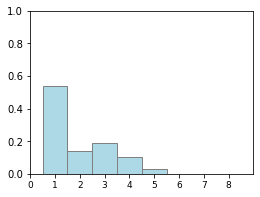

In [620]:
# --- 2 --- Cross-validation of PLS ------------------------------------------
# Outer
#   Inner
#     number LV
PerfoMetric, comparPred, outerCAL, totalCAL, optimal_nLV = optimise_PLS_CrossVal(
                        XX, YY, max_N_comp, unique_PatientID_Col,
                        Response_Col, min_rval, max_rval, p_threshold , 
                        outer_loop, inner_loop, outer_PropSele, inner_PropSele,
                        True)
# Calculate the Accuracy CI (confidence intervals)
data  = PerfoMetric.loc["Accuracy"].values.tolist()
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion

# Visuallize key results on accuracy and optimal LV number
print("\n")
print("Mode num. LV:  " + str(optimal_nLV) )
PerfoMetric["Mean"] = PerfoMetric.mean(axis=1)
print("Accuracy    :  " + str(round( PerfoMetric.mean(axis=1)["Accuracy"], 2))
                        + "  ( " +str(round(CI[0],4))+", "+str(round(CI[1],4))+ " )" ) 

pd.DataFrame( PerfoMetric["Mean"] )

# plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

In [ ]:
plot_metrics( outerCAL.T.values , 'ACCU', 'max', True)

In [ ]:
# --- 2 --- Cross-validation of PLS ------------------------------------------
# Outer
#   number LV
#     Inner
PerfoMetric, comparPred, outerCAL, totalCAL, optimal_nLV = optimise_PLS_CrossVal(
                        XX, YY, max_N_comp, unique_PatientID_Col,
                        Response_Col, min_rval, max_rval, p_threshold , 
                        outer_loop, inner_loop, outer_PropSele, inner_PropSele,
                        True)
# Calculate the Accuracy CI (confidence intervals)
data  = PerfoMetric.loc["Accuracy"].values.tolist()
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion

# Visuallize key results on accuracy and optimal LV number
print("\n")
print("Mode num. LV:  " + str(optimal_nLV) )
PerfoMetric["Mean"] = PerfoMetric.mean(axis=1)
print("Accuracy    :  " + str(round( PerfoMetric.mean(axis=1)["Accuracy"], 2))
                        + "  ( " +str(round(CI[0],4))+", "+str(round(CI[1],4))+ " )" ) 

pd.DataFrame( PerfoMetric["Mean"] )

# plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

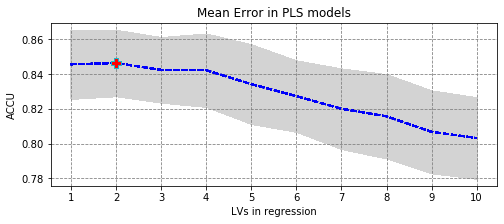

In [609]:
plot_metrics( outerCAL.T.values , 'ACCU', 'max', True)

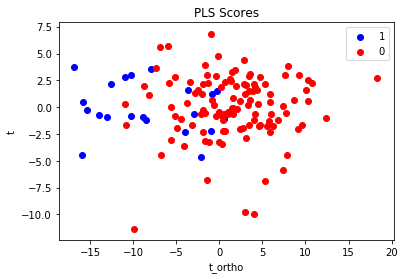

In [465]:
# ************************************************************
#                          O-PLS
# ************************************************************

from pyopls import *
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut, KFold
from sklearn.metrics import r2_score, accuracy_score



M_X = XX
M_Y = YY[Response_Col] # response
Resp_class1 = 0
Resp_class2 = 1
P_Threshold = 0.5
EvalResults = pd.DataFrame( 0 , index = ["Best_nLV", "Accuracy", "Specificity", "Sensitivity"],
                                columns = [ "o"+str(xx+1) for xx in range(5)] )
ooL = 0   


    
cv_split = KFold(n_splits=8, shuffle=False, random_state=None)

# Build PLS predicion model with N number of LV (for comparison to oPLS) 
pls = PLSRegression(1)

# Create the class OPLS, with the number of orthogonal components to filter
opls = OPLS(12)
# In sequence, fit the model to the data, then get the non-orthogonal 
# components of X (which are considered in prediction)
# I.e. Learn and apply filtering on the training data and get the filtered X, 
# called variable Z in the code
Z = opls.fit_transform(M_X, M_Y)
# Now that data is orthogonalized, we can Build PLS predicion model 
processed_y_pred     = cross_val_predict(pls, Z, M_Y, cv = cv_split)
processed_q_squared  = r2_score(M_Y, processed_y_pred)                   # 0.981
processed_dq_squared = r2_score(M_Y, np.clip(processed_y_pred, -1, 1))   # 0.984
processed_accuracy   = accuracy_score(M_Y, np.sign(processed_y_pred))    # 1.0


dff, Accu_Spe_Sele = binary_classification( M_Y.values, processed_y_pred.flatten(), 0.5 , 0, 1 )


EvalResults.iloc[:, ooL] = Accu_Spe_Sele


'''

comparPred = pd.DataFrame( [M_Y.tolist(), processed_y_pred, Y_pred_thres ] ).T
comparPred.columns = ["M_Y", "oY_pred", "Y_pred_thres"]

# ? ? ?
r2_X = opls.score(M_X)  # 7.8e-12 (most variance is removed)

fpr, tpr, thresholds = roc_curve(M_Y, y_pred)
roc_auc = roc_auc_score(M_Y, y_pred)
proc_fpr, proc_tpr, proc_thresholds = roc_curve(M_Y, processed_y_pred)
proc_roc_auc = roc_auc_score(M_Y, processed_y_pred)

plt.figure(0)
plt.plot(fpr, tpr, lw=2, color='blue', label=f'Unprocessed (AUC={roc_auc:.4f})')
plt.plot(proc_fpr, proc_tpr, lw=2, color='red',
         label=f'39-component OPLS (AUC={proc_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
'''

pls.fit(Z, M_Y)
df = pd.DataFrame(np.column_stack([pls.x_scores_, opls.T_ortho_[:, 0]]),
                  index=M_X.index, columns=['t', 't_ortho'])                           
pos_df = df[M_Y==1]
neg_df = df[M_Y==0]

plt.figure(1)
plt.scatter(pos_df['t'], pos_df['t_ortho'], c='blue',  label=1 )   # 'Cancer'
plt.scatter(neg_df['t'], neg_df['t_ortho'], c='red',   label=0 )   # 'Control'
plt.title('PLS Scores')
plt.xlabel('t_ortho')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()


In [62]:
opls.T_ortho_.shape

(230, 12)

In [63]:
pls.x_scores_.shape

(230, 1)

In [64]:
opls.P_ortho_.shape

(72, 12)

In [65]:
pls.x_loadings_.shape

(72, 1)

In [320]:
totalCAL

""


In [548]:
PerfoMetric


,o1,o2,o3,o4,o5,o6,o7,o8,o9,o10,...,o12,o13,o14,o15,o16,o17,o18,o19,o20,Mean
Accuracy,0.888889,0.888889,0.814815,0.851852,0.925926,0.888889,0.777778,0.851852,0.851852,0.962963,...,0.814815,0.851852,0.851852,0.888889,0.777778,0.814815,0.851852,0.925926,0.888889,0.857407
Specificity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913043,1.000000,1.000000,0.962963,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.993800
Sensitivity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Best_nLV,2.000000,1.000000,1.000000,8.000000,1.000000,4.000000,5.000000,3.000000,3.000000,4.000000,...,1.000000,4.000000,2.000000,3.000000,3.000000,4.000000,1.000000,3.000000,1.000000,2.850000


In [510]:
import scipy.stats as st

data  = totalCAL.values    # totalCAL.iloc[:,1].values
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion

In [511]:
CI

[array([0.82147488, 0.82172393, 0.8224235 , 0.82215032, 0.82172654,
        0.82080736, 0.82123748, 0.82204376, 0.82127932, 0.82219362]),
 array([0.84716148, 0.84691244, 0.84621286, 0.84648604, 0.84690983,
        0.84782901, 0.84739888, 0.84659261, 0.84735704, 0.84644275])]

In [575]:
# Calculate the Confidence intervals and add to PerfoMetric
data  = PerfoMetric.loc["Accuracy"].values.tolist()
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion
CI

[nan, nan]

In [595]:
PerfoMetric

,o1,o2,o3,o4,o5,o6,o7,o8,o9,o10,...,o22,o23,o24,o25,o26,o27,o28,o29,o30,Mean
Accuracy,0.925926,0.925926,0.962963,0.851852,0.777778,0.851852,0.925926,0.814815,0.888889,0.814815,...,0.851852,0.888889,0.777778,0.888889,0.777778,0.777778,0.851852,0.888889,0.777778,0.844444
Specificity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.913043,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991023
Sensitivity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Best_nLV,1.000000,2.000000,1.000000,6.000000,4.000000,2.000000,4.000000,3.000000,2.000000,1.000000,...,7.000000,1.000000,4.000000,7.000000,2.000000,2.000000,1.000000,1.000000,3.000000,3.233333
